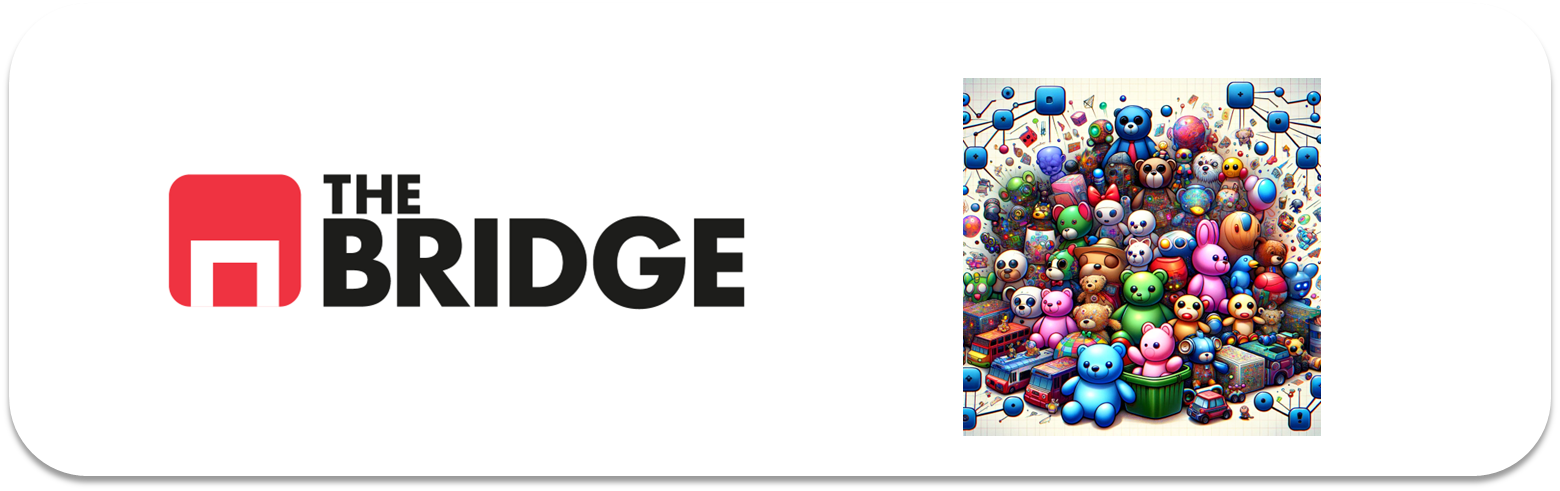

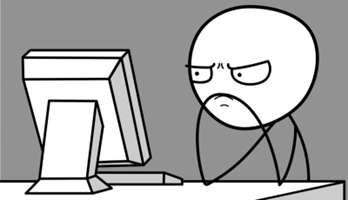

## PRACTICA OBLIGATORIA: DBSCAN y CLUSTERING JERARQUICO

* La práctica obligatoria de esta unidad consiste en un ejercicio de modelado no supervisado aplicado a clustering jerárquico y no jerárquico. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [1]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from itertools import combinations
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# Parte I. Modelado

### Descripción del problema.

En una planta de experimentación con nuevas bebidas energéticas están trabajando con diferentes mezclas de componentes para obtener posibles variedades de su producto estrella "NonstopU". El problema es que la fabricación de cada "prototipo" conlleva demasiado tiempo y las pruebas de sabores y de propiedades "non-stop" antisueño y antifatiga son costosas.  

En ese sentido quieren construir algún sistema de segmentación previa de mezclas sin probarlas solo indicando las cantidades de cada componente de la bebida. Tienen datos pero desgraciadamente de mezclas anteriores con diferentes medidas pero que por temas presupuestarios y de prioridad no se hicieron test con usuarios y potenciales clientes, es decir no tienen un target de capacidad antifatiga o de preferencia del usuario que puedas servirles para construir un clasificador clásico como han hecho otras veces.  

Han acudido a vosotros con la necesida de encontrar ese segmentador de posibles bebidas y con los datos de las mezclas no probadas anteriores por ver si vosotros podéis ayudarles a encontrar algún tipo de segmentación que luego ello se encargarían de interpretar. No es requisito obligatorio pero les gustaría también poder establecer algún tipo de relación entre las segmentaciones (tipo cuales segmentos se "parecerían" más entre sí)

NOTA ORIENTATIVA: Los químicos no esperan que haya menos de 3 segmentos ni más de 5.  
NOTA OPERATIVA: El dataset con los datos que nos han dado los químicos está en "./data/empowering_drinks.csv"

**Se pide**: Construir al menos dos algoritmos de clustering (DBSCAN debe ser uno de ellos y el otro debería estar claro cual deberíamos usar dado el enunciado). Compararlos brevemente aunque sea meramente especulativo (¿Por qué es espculativo?)

**Se recomienda**: Visualizar las features dos a dos para escoger las mejores, no necesariamente hay que usar todas, ni tampoco quedarse en dos. Probar diferentes hiperparámetros en función de la nota orientativa y explicar porqué se han escogido los que finalmente se hayan escogido. 

Recuerda que el proceso es similar a lo que vimos en el otro tipo de aprendizaje:
1. Entender el problema
2. Cargar datos, visualizar.
3. MiniEDA: Selección de features
4. Tratamiento de Features.
5. Selección de modelos, selección de hiperparámetros
6. Entrenamiento, visualización de resultados.
7. Discusión de los mismos


## 1. Entender el **problema**

Vamos a emplear 
- DBSCAN porque nos lo piden explicitamente 
- y además un clustering jerárquico (aglomerativo o bottom-up) porque necesitamos establecer algún tipo de relación entre los clústeres encontrados ( *"que segementos se parecen mas entre si"*)

*Por otro lado, esperaremos encontrar entre 3 y 5 clústeres pero en el caso de DBSCAN no jugaremos con ese hiperparámetro, y en el del clústering jerárquico lo comprobaremos con el método del máximo gap*

## 2. **Cargar datos, visualizar**

In [2]:
train_set = pd.read_csv("./data/empowering_drinks.csv", sep = "|")
train_set

Azúcares  Vitamínas del grupo B   Cafeína  Ácido Cítrico   Taurina
0    1.518613               0.232053  1.034819       1.013009  0.251717
1    0.246290              -0.827996  0.733629       0.965242 -0.293321
2    0.196879               1.109334  1.215533       1.395148  0.269020
3    1.691550               0.487926  1.466525       2.334574  1.186068
4    0.295700               1.840403  0.663351      -0.037874 -0.319276
..        ...                    ...       ...            ...       ...
148  0.493343               0.414820 -1.284344       0.009893  0.969783
149  0.332758              -0.389355 -1.344582       0.280575  2.224236
150  0.209232               0.012732 -1.354622       0.296498  1.834923
151  1.395086               1.365208 -1.274305      -0.595160  1.791666
152  0.019564               0.039106 -1.500000       0.081020  0.500000

[153 rows x 5 columns]

*Los valores tienen pinta de haber sido escalados y preparados ya para trabajar sobre ellos, veamos con un describe*

In [3]:
train_set.describe()

Azúcares  Vitamínas del grupo B     Cafeína  Ácido Cítrico  \
count  153.000000             153.000000  153.000000     153.000000   
mean     0.019231               0.037273    0.041057       0.080022   
std      1.026182               0.995984    1.040928       1.009450   
min     -2.434235              -3.679162   -1.695971      -1.493188   
25%     -0.816038              -0.499016   -1.043392      -0.738463   
50%      0.061000              -0.023821    0.211566      -0.165254   
75%      0.876275               0.707247    0.894264       0.917474   
max      2.259772               3.156325    3.062832       2.971473   

          Taurina  
count  153.000000  
mean    -0.044088  
std      0.934399  
min     -1.634288  
25%     -0.799428  
50%     -0.154899  
75%      0.493956  
max      2.431870

*Los valores max y min no coinciden, pero efectivamente tienen medias cercanas a 0 y desviaciones cercanas a 1, con lo que si, **ESTAN ESTANDARIZADOS**, con lo que esta parte me la ahorro*

In [4]:
train_set.describe().T["min"].min()

-3.6791622340370105

In [5]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Azúcares               153 non-null    float64
 1   Vitamínas del grupo B  153 non-null    float64
 2   Cafeína                153 non-null    float64
 3   Ácido Cítrico          153 non-null    float64
 4   Taurina                153 non-null    float64
dtypes: float64(5)
memory usage: 6.1 KB


*153 experimentos sin nulos aparentemente, todo variable numéricas*

## 3. **MiniEDA**

La idea es 
- *comprobar las relaciones entre las variables* para intentar observar alguna *posible clusterizacion*
- y así además *seleccionar variables*
- y por supuesto *comprobar si hay que transformar y escalar (esto normalmente siempre)* 

##### 3.1 RELACIONES: 

*Comprobamos las relaciones dos a dos con un pairplot y con alguna de las funciones de nuestra biblioteca particular*

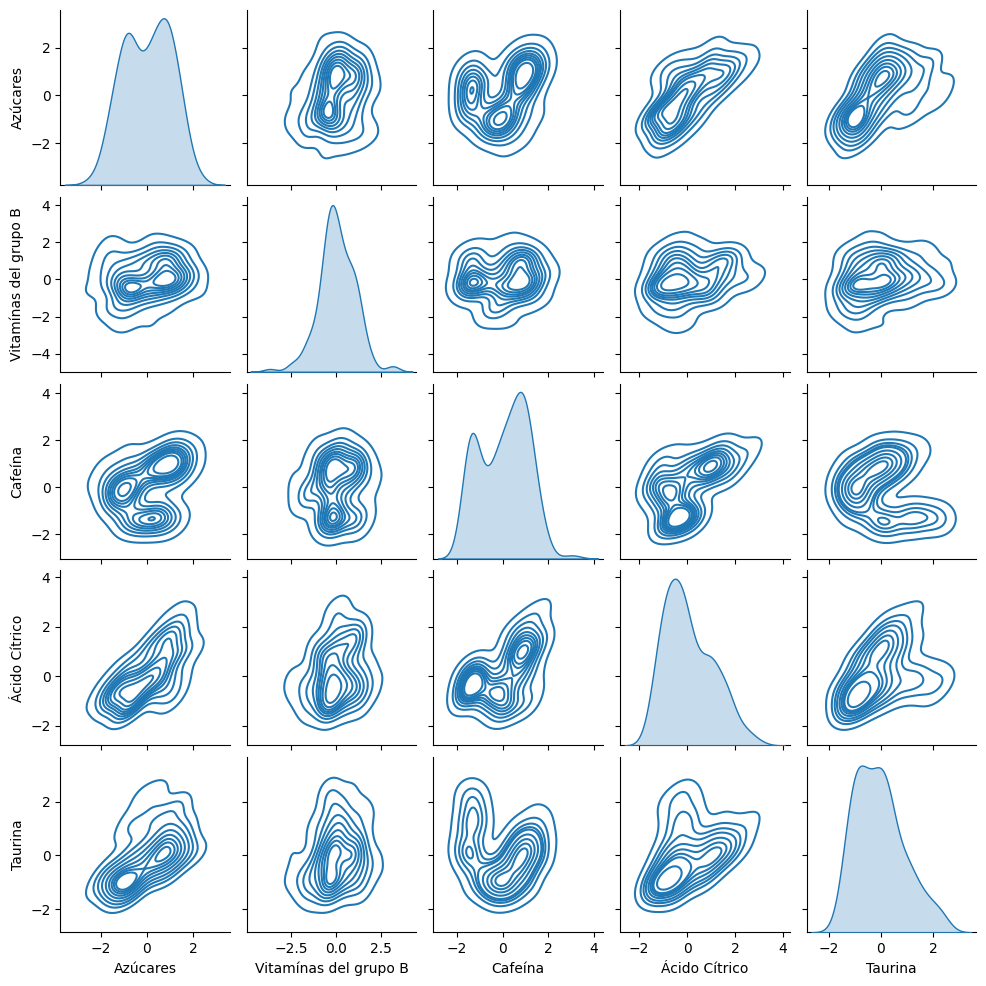

In [6]:
sns.pairplot(train_set, kind='kde', height=2)

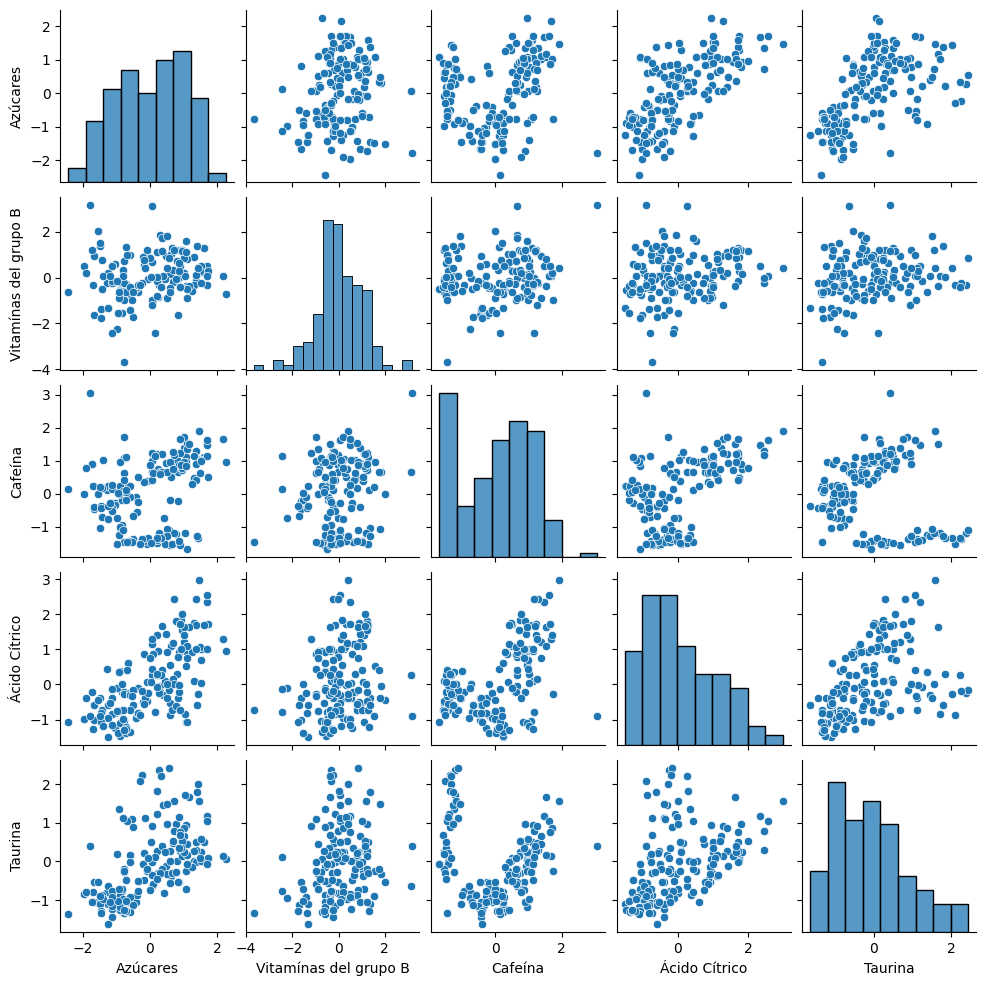

In [7]:
sns.pairplot(train_set, height=2)

*Así de primeras es difícil encontrar clusteres tipo mancha (blobs) o radiales separados ente sí que invitaran a un Kmeans, tampoco se ve de primeras otras separaciones, parecen todo brochazos.* 

*Por eso no nos queda más remedio que ver gráfico a gráfico o ir directamente a tratar las variables y luego a por los hiperparámetros. Pero esta vez (porque son pocas features) sacaremos los scatter*

In [8]:
# Hazme todas las combinaciones 2 a 2) eliminandome las redundantes

for valores in combinations(train_set.columns, r = 2): # itertools
    print(valores)

('Azúcares', 'Vitamínas del grupo B')
('Azúcares', 'Cafeína')
('Azúcares', 'Ácido Cítrico')
('Azúcares', 'Taurina')
('Vitamínas del grupo B', 'Cafeína')
('Vitamínas del grupo B', 'Ácido Cítrico')
('Vitamínas del grupo B', 'Taurina')
('Cafeína', 'Ácido Cítrico')
('Cafeína', 'Taurina')
('Ácido Cítrico', 'Taurina')


Azúcares vs Vitamínas del grupo B


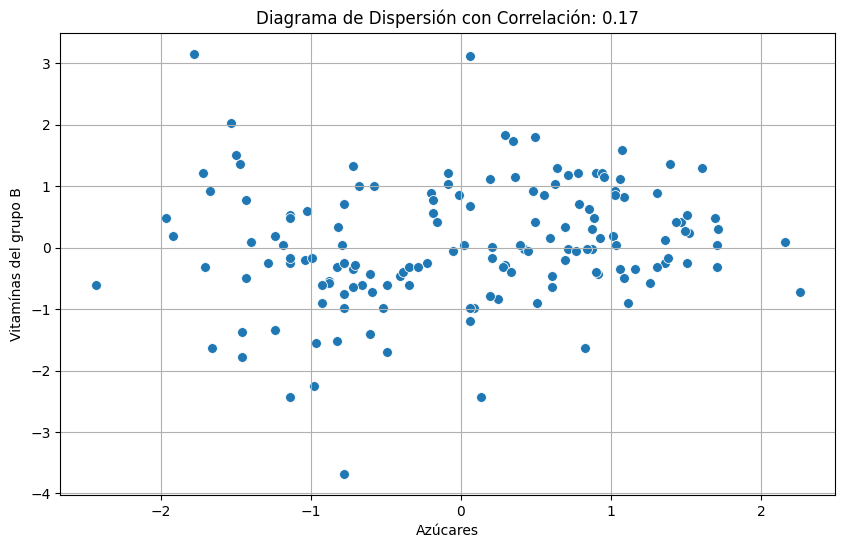

Azúcares vs Cafeína


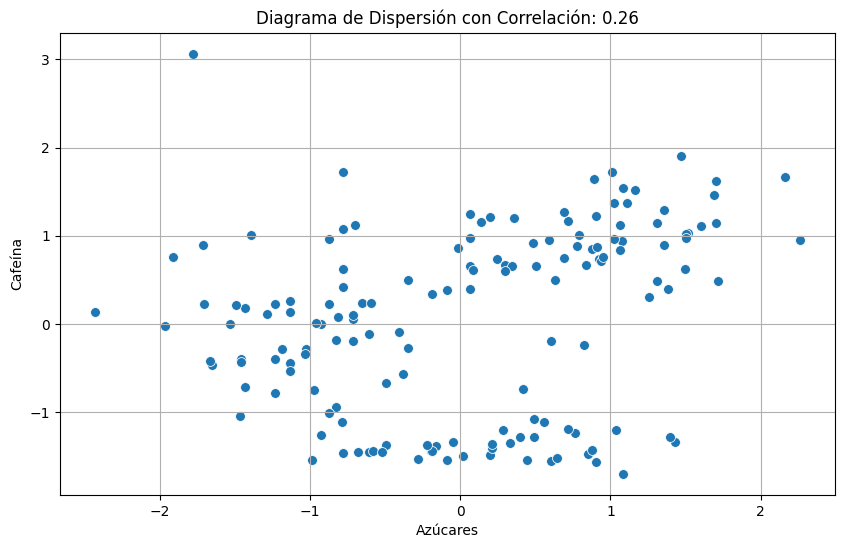

Azúcares vs Ácido Cítrico


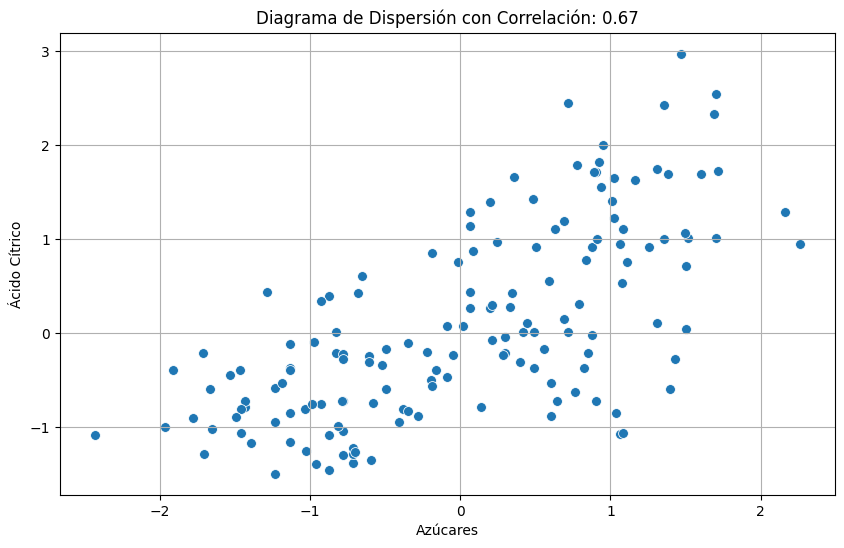

Azúcares vs Taurina


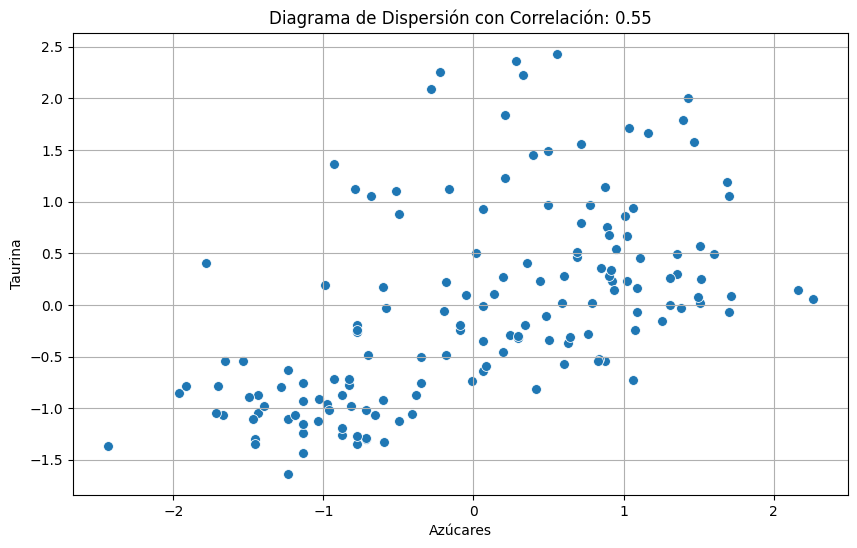

Vitamínas del grupo B vs Cafeína


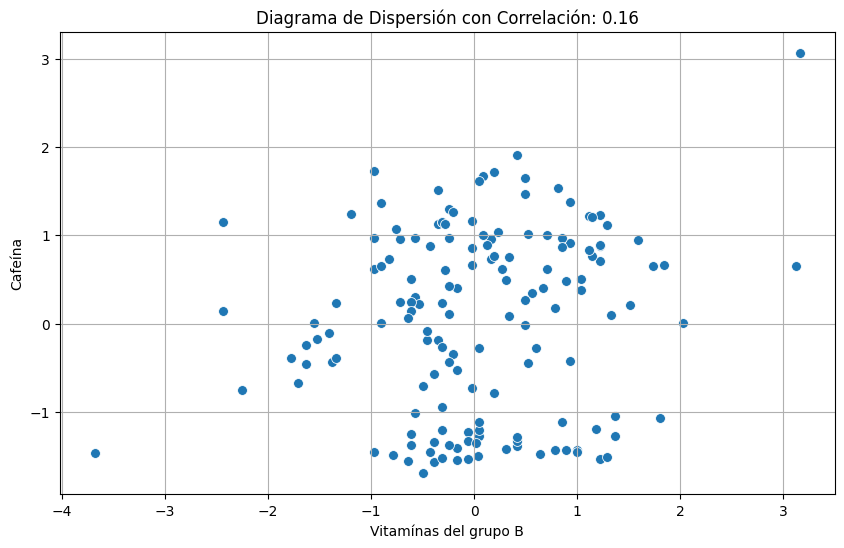

Vitamínas del grupo B vs Ácido Cítrico


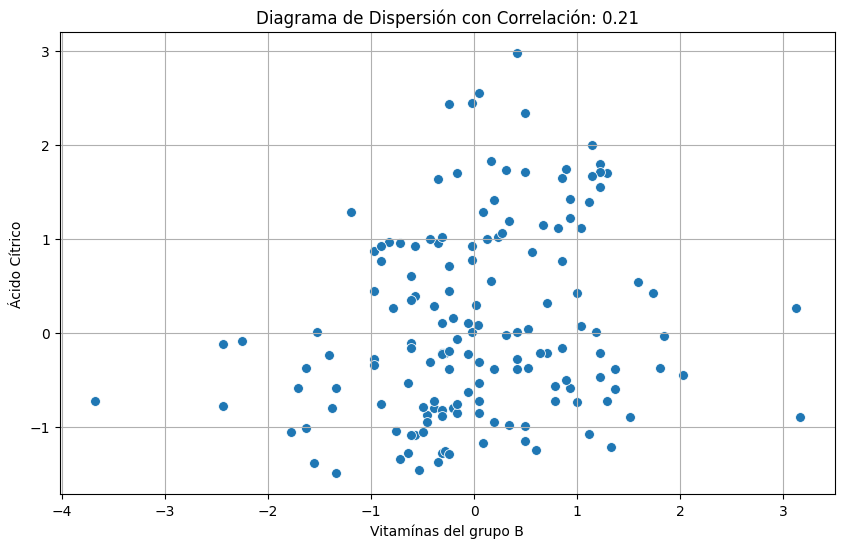

Vitamínas del grupo B vs Taurina


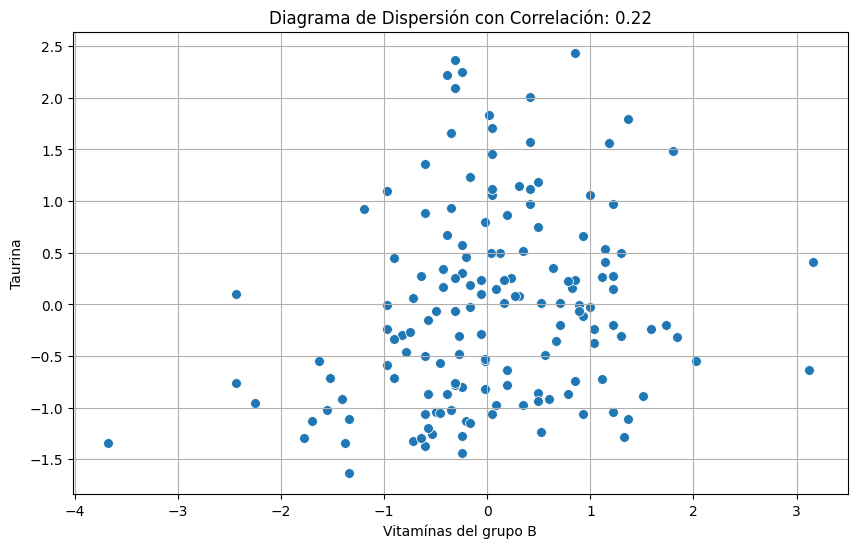

Cafeína vs Ácido Cítrico


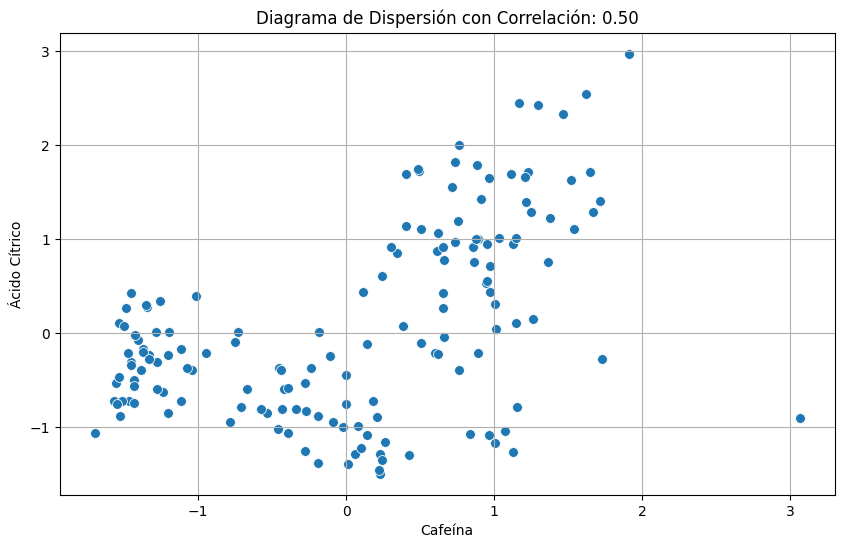

Cafeína vs Taurina


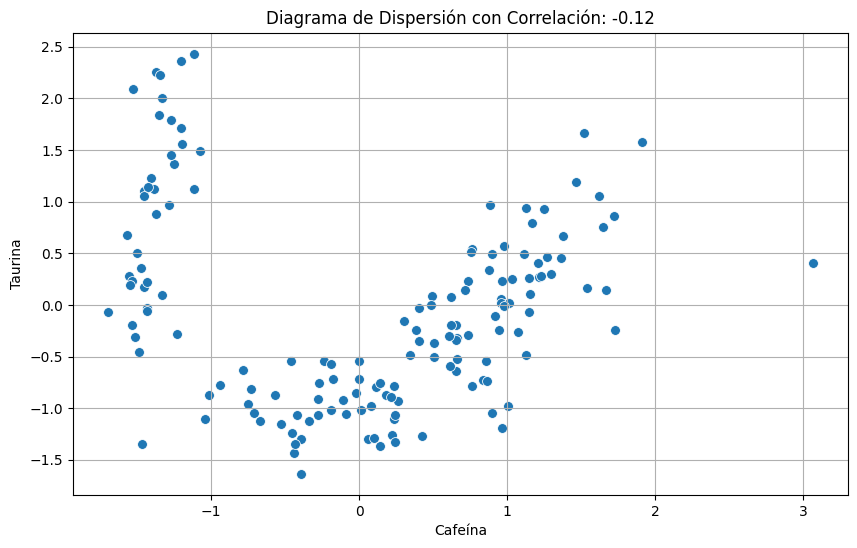

Ácido Cítrico vs Taurina


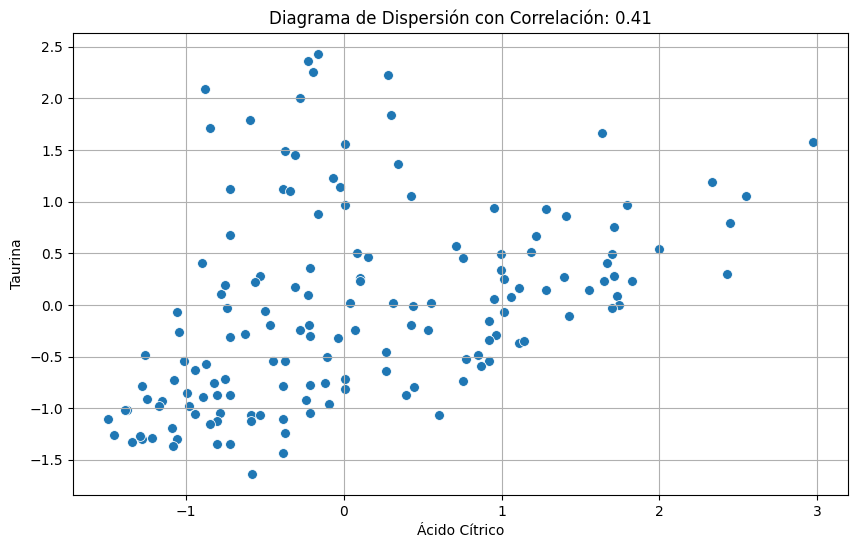

In [9]:
for x, y in combinations(train_set.columns, r = 2):
    
    print(f"{x} vs {y}")
    bt.grafico_dispersion_con_correlacion(train_set, x, y, mostrar_correlacion= True )

| Variable 1       | Variable 2       | Observaciones |
|-----------------|-----------------|--------------|
| Azúcares       | Vitaminas B      | Brochazo y no se ven formaciones claras. |
| Azúcares       | Cafeína          | No es exactamente un brochazo, quizás dos separaciones: una línea superior y otra inferior. Nada concluyente. |
| Azúcares       | Ácido Cítrico    | Otro brochazo sencillo, nada concluyente. |
| Azúcares       | Taurina          | Similar a la anterior. |
| Vitaminas B    | Cafeína          | Quizás un grupo pequeño a la izquierda, uno superior y un trazo inferior. |
| Vitaminas B    | Ácido Cítrico    | Nada concluyente. |
| Vitaminas B    | Taurina          | Similar al anterior. |
| Cafeína        | Ácido Cítrico    | Quizás un cluster a la izquierda, y uno como un trazo o dos en ese trazo diagonal. |
| Cafeína        | Taurina          | Se ven dos agrupaciones separadas a la izquierda en vertical y otra que podrían ser dos aunque no está claro. Estas dos variables parecen más interesantes. |
| Ácido Cítrico  | Taurina          | Puesto a soñar, podría haber tres clusters, pero no se ve nada concluyente. |


*En esta situación voy a probar dos juegos de features, uno completo y otro sólo con cafeína y taurina (que además tiene pinta de que en temas de energización pintan algo)*

In [10]:
features_short = ["Taurina", "Cafeína"]
features = train_set.columns.to_list()

## 4. **Tratamiento de features**

##### 4.1. Transformaciones

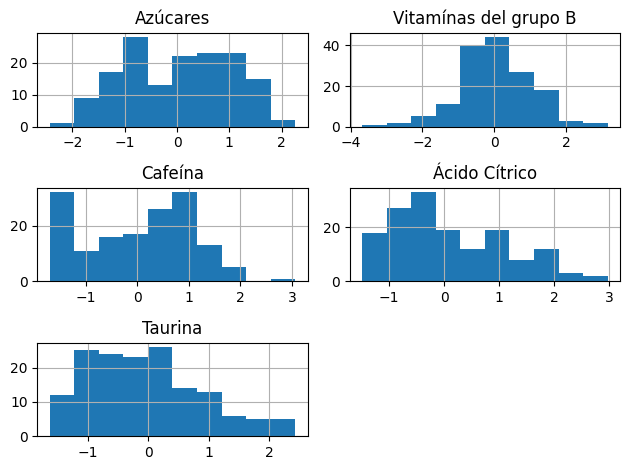

In [11]:
# comprobación de transformaciones
train_set.hist()
plt.tight_layout()

*Quizás podríamos transformar alguna pero dado que los valores ya están prácticamente escalados (ver el describe de arriba), no tocamos más*

##### 4.2. Escalado

In [12]:
train_set.describe().loc[['mean', 'std']]

# media entorno al 0 y std 1

Azúcares  Vitamínas del grupo B   Cafeína  Ácido Cítrico   Taurina
mean  0.019231               0.037273  0.041057       0.080022 -0.044088
std   1.026182               0.995984  1.040928       1.009450  0.934399

*Tal como se vio en el análisis preliminar las variables parecen tratadas y no hay que tocar el dataset*

## 5. **HIPERPARÁMETROS**

*Ajuste de hiperparámetros* 
- selección de eps
- min_samples 
- numero de clusters (para el jerárquico)

### 5.1. **DBSCAN**

En este caso aplicamos lo que vimos en los ejercicios: 
- iterar sobre rangos de estos dos hiperparámetros **(EPS y min_samples)** midiendo el **porcentaje de "anomalías"** que detecta
- considerando como punto de parada un valor por debajo del 10% de anomalias
- y con el objetivo de encontrar entre 3-5 clusteres (como solicitaba el enunciado)

#### 5.1.1 Para el **juego completo de features**

In [13]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Azúcares               153 non-null    float64
 1   Vitamínas del grupo B  153 non-null    float64
 2   Cafeína                153 non-null    float64
 3   Ácido Cítrico          153 non-null    float64
 4   Taurina                153 non-null    float64
dtypes: float64(5)
memory usage: 6.1 KB


*Es importante fijarnos en la escala y en el numero de puntos que existen (153), considerando como punto de partida el scatter Cafeína-Taurina, poner min_samples > 10 no parece tener mucho sentido por el relativamente pequeño número de puntos que hay, así que **vamos a probar con 3, 5 y 10 puntos para considerar un vecindario como un vecindario de instancia core (min_sample)**

In [14]:
np.linspace(0.001,6,100) # Generacion de 100 valores equidistantes entre 0.001 y 6

array([1.00000000e-03, 6.15959596e-02, 1.22191919e-01, 1.82787879e-01,
       2.43383838e-01, 3.03979798e-01, 3.64575758e-01, 4.25171717e-01,
       4.85767677e-01, 5.46363636e-01, 6.06959596e-01, 6.67555556e-01,
       7.28151515e-01, 7.88747475e-01, 8.49343434e-01, 9.09939394e-01,
       9.70535354e-01, 1.03113131e+00, 1.09172727e+00, 1.15232323e+00,
       1.21291919e+00, 1.27351515e+00, 1.33411111e+00, 1.39470707e+00,
       1.45530303e+00, 1.51589899e+00, 1.57649495e+00, 1.63709091e+00,
       1.69768687e+00, 1.75828283e+00, 1.81887879e+00, 1.87947475e+00,
       1.94007071e+00, 2.00066667e+00, 2.06126263e+00, 2.12185859e+00,
       2.18245455e+00, 2.24305051e+00, 2.30364646e+00, 2.36424242e+00,
       2.42483838e+00, 2.48543434e+00, 2.54603030e+00, 2.60662626e+00,
       2.66722222e+00, 2.72781818e+00, 2.78841414e+00, 2.84901010e+00,
       2.90960606e+00, 2.97020202e+00, 3.03079798e+00, 3.09139394e+00,
       3.15198990e+00, 3.21258586e+00, 3.27318182e+00, 3.33377778e+00,
      

In [15]:
outlier_percent = []
experiments = {}

for min_samples in [3,5,10]:
    print(f"Min_samples = {min_samples}") # minimo de vecinos
    
    outlier_percent = []
    
    # Probará todas las distancias EPS (epsilon para valor 3, valor 5, y valor 10)
   
    for eps in np.linspace(0.001,6,100): # Genera 100 valores equidistantes entre 0.001 y 6
        
        # Creamos el modelo (Probará 100 pruebas para el valor de 3, otras 100 para 5 y otras para 10)
        dbscan = DBSCAN(eps=eps, 
                        min_samples=min_samples) 
                        # min_samples dos veces el ´numero de features -> 2 por dimensión del hiperespacio en el que representamos el conjunto de puntos... 
                        # No le des muchas vueltas es un número muy orientativo. Pero piensa que si fuera un recta querrías 2 valores, un plano 4, un cubo 6...
        
        # Entrena
        dbscan.fit(train_set)
        
        # Registramos el porcentaje de anomalías (recuerda que se etiquetan como -1)
        perc_outliers = 100 * np.sum(dbscan.labels_ == -1) / len(dbscan.labels_) # Atributos: dbscan.labels_
        
        #if perc_outliers <= 10:
        #    print(perc_outliers, dbscan.labels_)
        #    print(len(dbscan.labels_))
        #    print(pd.Series(dbscan.labels_).value_counts())
        
        outlier_percent.append(perc_outliers)
    
    experiments[min_samples] = outlier_percent.copy()

Min_samples = 3
Min_samples = 5
Min_samples = 10


In [16]:
len(experiments[3])

100

##### **visualización EPS - % ANOMALIAS**

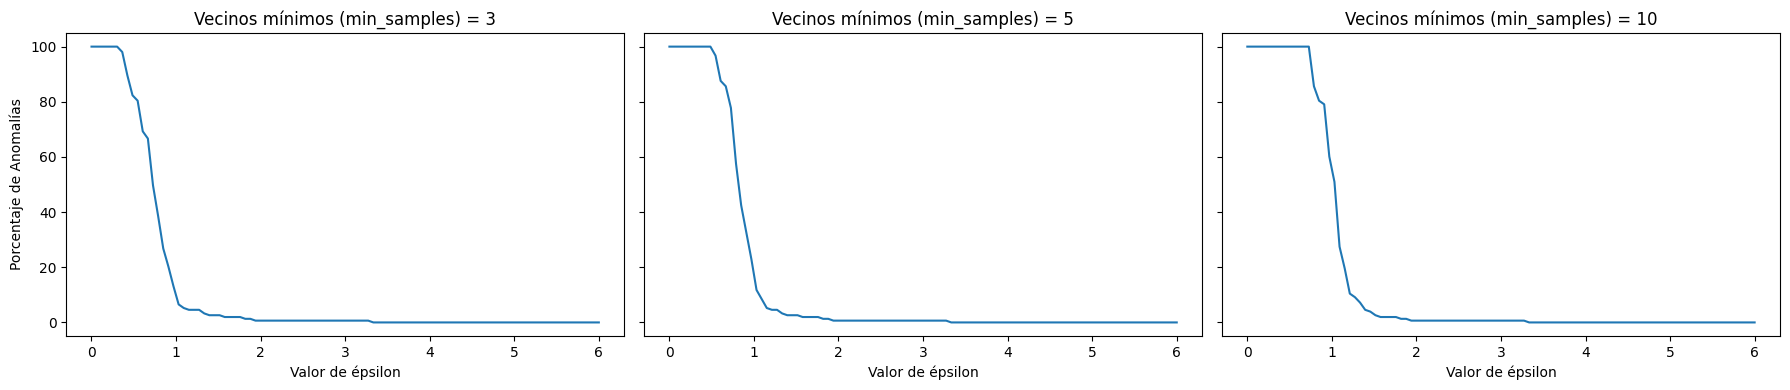

In [17]:
# visualizamos el % de anomalias (que va bajando a medida que aumenta el valor de nuetras distancia EPSILON)
fig, axes = plt.subplots(1, 3, figsize=(18, 4), dpi=100, sharey=True)

for i, min_samples in enumerate([3, 5, 10]):
    sns.lineplot(ax=axes[i], 
                 x=np.linspace(0.001, 6, 100),             
                 y=experiments[min_samples])
    
    axes[i].set_ylabel("Porcentaje de Anomalías")
    axes[i].set_xlabel("Valor de épsilon")
    axes[i].set_title(f"Vecinos mínimos (min_samples) = {min_samples}")

plt.tight_layout()
plt.show()

Entre 1.2 y 2 podríamos situar la `eps` que nos reduce las anomalías a menos de un 10%. Comprobemos:

In [18]:
for min_samples in [3,5,10]:
    print(f"Para num_samples = {min_samples}:")
    for indice, valor in enumerate(np.linspace(0.001,6,100)):
        
        if 1.2 <= valor <= 2:
            print(f"    EPS:    {round(valor,4)}    ->     {round(experiments[min_samples][indice],4)} %     de anomalias")
    
    print("")

Para num_samples = 3:
    EPS:    1.2129    ->     4.5752 %     de anomalias
    EPS:    1.2735    ->     4.5752 %     de anomalias
    EPS:    1.3341    ->     3.268 %     de anomalias
    EPS:    1.3947    ->     2.6144 %     de anomalias
    EPS:    1.4553    ->     2.6144 %     de anomalias
    EPS:    1.5159    ->     2.6144 %     de anomalias
    EPS:    1.5765    ->     1.9608 %     de anomalias
    EPS:    1.6371    ->     1.9608 %     de anomalias
    EPS:    1.6977    ->     1.9608 %     de anomalias
    EPS:    1.7583    ->     1.9608 %     de anomalias
    EPS:    1.8189    ->     1.3072 %     de anomalias
    EPS:    1.8795    ->     1.3072 %     de anomalias
    EPS:    1.9401    ->     0.6536 %     de anomalias

Para num_samples = 5:
    EPS:    1.2129    ->     4.5752 %     de anomalias
    EPS:    1.2735    ->     4.5752 %     de anomalias
    EPS:    1.3341    ->     3.268 %     de anomalias
    EPS:    1.3947    ->     2.6144 %     de anomalias
    EPS:    1.4553    

In [19]:
dbscan.labels_ # los son las anomalias

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

*Para asegurarnos nos quedamos con eps = 1.3 para los tres rangos de min_samples (menos de un 10% anomalias en las 3 combinaciones)* 

*Vamos a ver ahora cuantos clusters se forman para esos valores de hiperparámetros y si están entre 3 y 5 (num de clusters) que son los que nos sugirieron los químicos en el enunciado*

In [20]:
print("NUMERO DE CLUSTERS para EPS = 1.3 por min_samples \n")

for min_samples in [3,5,10]:
    
    dbscan = DBSCAN(eps = 1.3, 
                    min_samples = min_samples)
    
    dbscan.fit(train_set)
    
    print(f"- Para min_samples de {min_samples} vecinos: {pd.Series(dbscan.labels_).nunique() - 1} clusters")

NUMERO DE CLUSTERS para EPS = 1.3 por min_samples 

- Para min_samples de 3 vecinos: 1 clusters
- Para min_samples de 5 vecinos: 1 clusters
- Para min_samples de 10 vecinos: 1 clusters


*No distingue clústeres, para aumentar el número lo mejor es reducir el eps, probemos con 1.2 que todavía daba % de anomalías bajos*

In [21]:
print("NUMERO DE CLUSTERS para EPS = 1.2 por min_samples \n")

for min_samples in [3,5,10]:
    
    dbscan = DBSCAN(eps = 1.2, 
                    min_samples = min_samples)
    
    dbscan.fit(train_set)
    
    print(f"- Para min_samples de {min_samples} vecinos: {pd.Series(dbscan.labels_).nunique() - 1} clusters")

NUMERO DE CLUSTERS para EPS = 1.2 por min_samples 

- Para min_samples de 3 vecinos: 1 clusters
- Para min_samples de 5 vecinos: 1 clusters
- Para min_samples de 10 vecinos: 3 clusters


*Solo para 10 vecinos, logramos los 3 clusteres.* 
- *El problema es que ya nos vamos a más de un 10% de anomalías*

##### **min_samples = 10 - EPS: 1.2**
- Para min_samples de 10 vecinos: 3 clusters

*El problema es que ya nos vamos a más de un 10% de anomalías*

*En cualquier caso vamos a ver cómo queda esa clusterizacion **(eps = 1.2, min_samples = 10)**, aprovechando que es el último modelo entrenado*

In [22]:
train_set_all = train_set.copy()

train_set_all["Cluster"] = dbscan.labels_

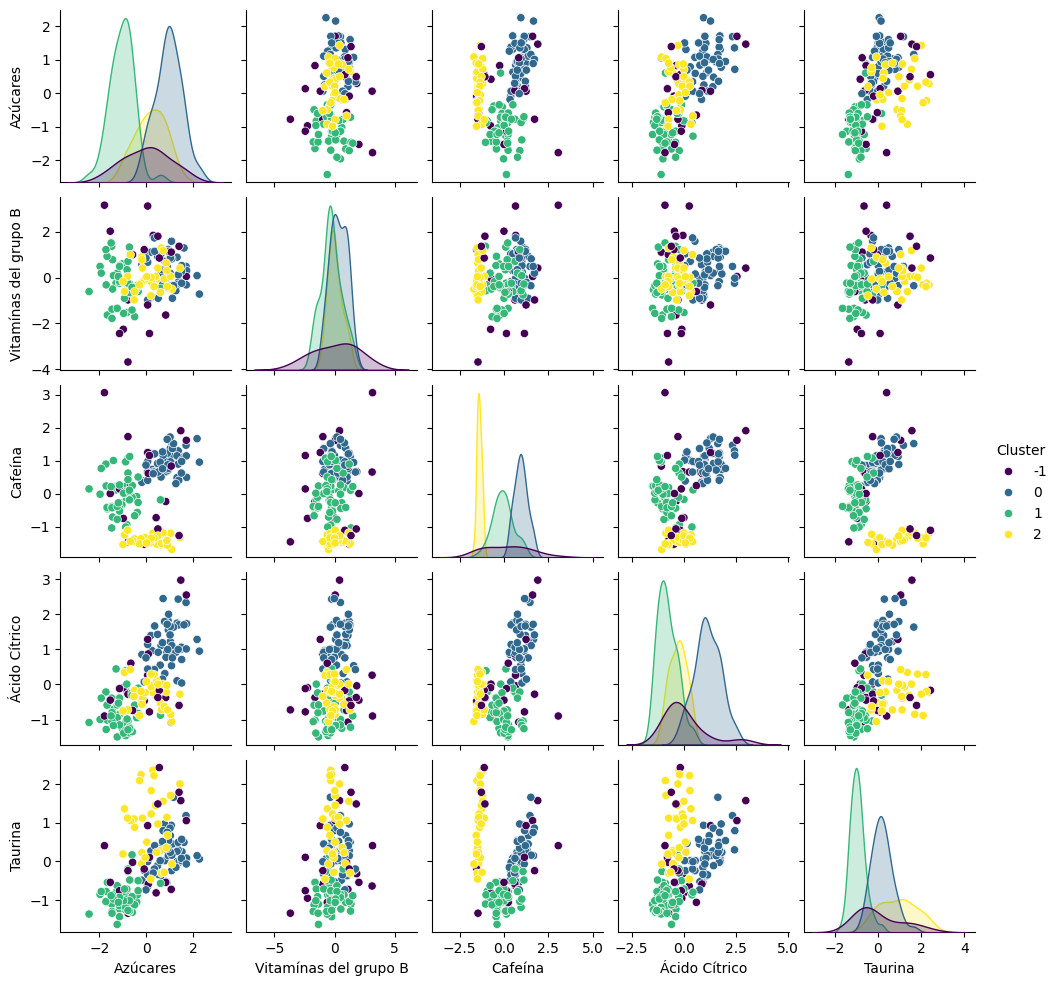

In [23]:
sns.pairplot(train_set_all, 
             hue="Cluster", 
             palette="viridis", 
             height=2)

*En general, no se puede interpretar demasiado bien en ninguna, salvo en Cafeína-Taurina y Cafeína-Azucares donde se parece al clustering que habíamos intuido.* 

<Axes: xlabel='Cafeína', ylabel='Taurina'>

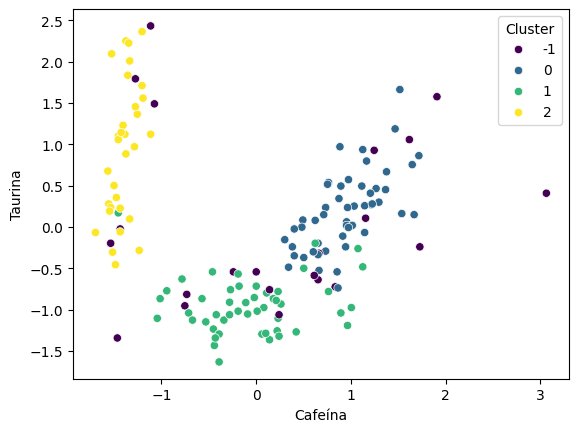

In [24]:
sns.scatterplot(data = train_set_all[["Cafeína","Taurina","Cluster"]], 
                x= "Cafeína", 
                y = "Taurina", 
                hue = "Cluster", 
                palette="viridis")

*En principio nos quedaríamos con la configuración todas las features, eps = 1.2, min_samples = 10*

#### 5.1.2 Para el **juego de dos features**

Pero probemos con menos features*

*Este es un caso en el que probablemente demasiadas features engañen al modelo, vamos a probar con nuestras dos features que parecían más prometedoras:*

In [25]:
train_set[features_short]

Taurina   Cafeína
0    0.251717  1.034819
1   -0.293321  0.733629
2    0.269020  1.215533
3    1.186068  1.466525
4   -0.319276  0.663351
..        ...       ...
148  0.969783 -1.284344
149  2.224236 -1.344582
150  1.834923 -1.354622
151  1.791666 -1.274305
152  0.500000 -1.500000

[153 rows x 2 columns]

In [26]:
outlier_percent = []
experiments = {}
for min_samples in [3,5,10]:
    print(f"Min_samples = {min_samples}")
    outlier_percent = []
    
    for eps in np.linspace(0.001,6,100): # Genera 50 valores equidistantes entre 0.001 y 3
        
        # Creamos el modelo
        dbscan = DBSCAN(eps=eps,min_samples=min_samples) # min_samples dos veces el ´numero de features -> 2 por dimensión del hiperespacio en el que representamos el conjunto de puntos... No le des muchas vueltas es un número muy orientativo. Pero piensa que si fuera un recta querrías 2 valores, un plano 4, un cubo 6...
        dbscan.fit(train_set[features_short])
        
        # Registramos el porcentaje de anomalías (recuerda que se etiquetan como -1)
        perc_outliers = 100 * np.sum(dbscan.labels_ == -1) / len(dbscan.labels_)
        
        #if perc_outliers <= 10:
        #    print(perc_outliers, dbscan.labels_)
        #    print(len(dbscan.labels_))
        #    print(pd.Series(dbscan.labels_).value_counts())
        outlier_percent.append(perc_outliers)
    
    experiments[min_samples] = outlier_percent.copy()

Min_samples = 3
Min_samples = 5
Min_samples = 10


##### **visualización EPS - % ANOMALIAS**

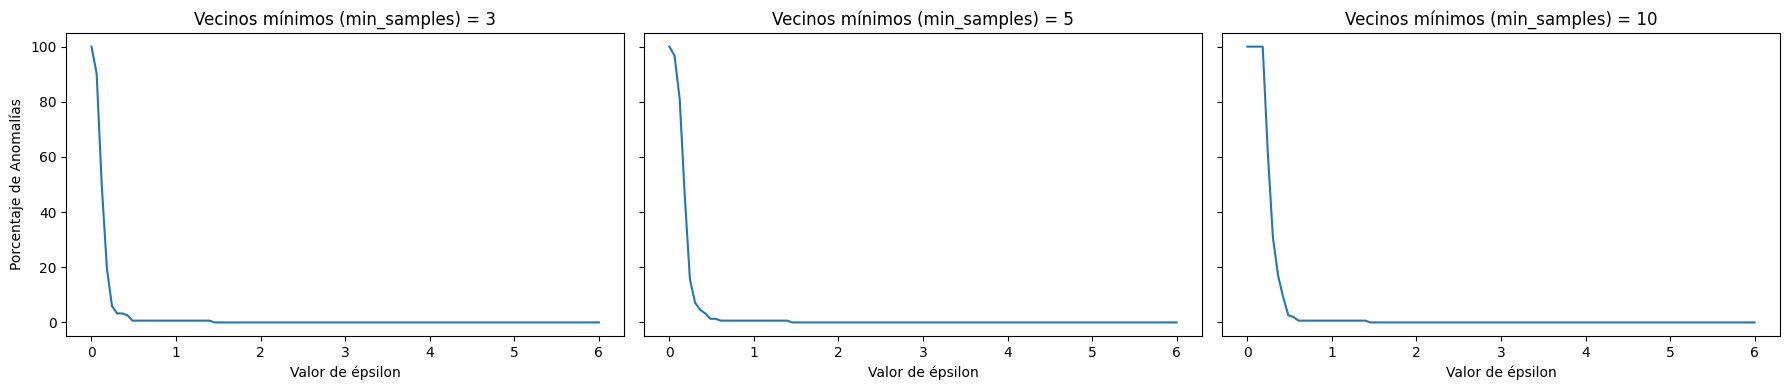

In [27]:
# visualizamos el % de anomalias (que va bajando a medida que aumenta el valor de nuetras distancia EPSILON)
fig, axes = plt.subplots(1, 3, figsize=(18, 4), dpi=100, sharey=True)

for i, min_samples in enumerate([3, 5, 10]):
    sns.lineplot(ax=axes[i], 
                 x=np.linspace(0.001, 6, 100),             
                 y=experiments[min_samples])
    
    axes[i].set_ylabel("Porcentaje de Anomalías")
    axes[i].set_xlabel("Valor de épsilon")
    axes[i].set_title(f"Vecinos mínimos (min_samples) = {min_samples}")

plt.tight_layout()
plt.show()

*Para eps = 0.5 aproximadamente los tres ejemplos caen en el número de anomalias. Probemos para ese rango cuantos clusteres nos salen*

In [28]:
print("NUMERO DE CLUSTERS para EPS = 0.5 por min_samples \n")

for min_samples in [3,5,10]:
    dbscan = DBSCAN(eps = 0.5, min_samples = min_samples)
    dbscan.fit(train_set[features_short])
    print(f"- Para min_samples de {min_samples} vecinos: {pd.Series(dbscan.labels_).nunique() - 1} clusters")

NUMERO DE CLUSTERS para EPS = 0.5 por min_samples 

- Para min_samples de 3 vecinos: 2 clusters
- Para min_samples de 5 vecinos: 2 clusters
- Para min_samples de 10 vecinos: 2 clusters


*Hmmm, mejor pero no está en el rango, para conseguir más clústeres hacemos como con todas las features, reducimos ligeramente eps, por ejemplo a 0.3*

In [29]:
print("NUMERO DE CLUSTERS para EPS = 0.3 por min_samples \n")
for min_samples in [3,5,10]:
    
    dbscan = DBSCAN(eps = 0.3, 
                    min_samples = min_samples)
    
    dbscan.fit(train_set[features_short])
    print(f"- Para min_samples de {min_samples} vecinos: {pd.Series(dbscan.labels_).nunique() - 1} clusters")

NUMERO DE CLUSTERS para EPS = 0.3 por min_samples 

- Para min_samples de 3 vecinos: 3 clusters
- Para min_samples de 5 vecinos: 4 clusters
- Para min_samples de 10 vecinos: 3 clusters


*Curiosamente con 5 vecinos se nos va a 4 clusteres, por equiparar con todas las features veamos el último ejemplo*

##### **min_samples = 10 - EPS: 0.3**
- Para min_samples de 10 vecinos: 3 clusters


In [30]:
pd.Series(dbscan.labels_).value_counts()

 0    51
-1    49
 1    40
 2    13
Name: count, dtype: int64

In [31]:
train_set_2feat = train_set.copy()

train_set_2feat["Cluster"] = dbscan.labels_ #pq es el ultimo que hemos entrenado

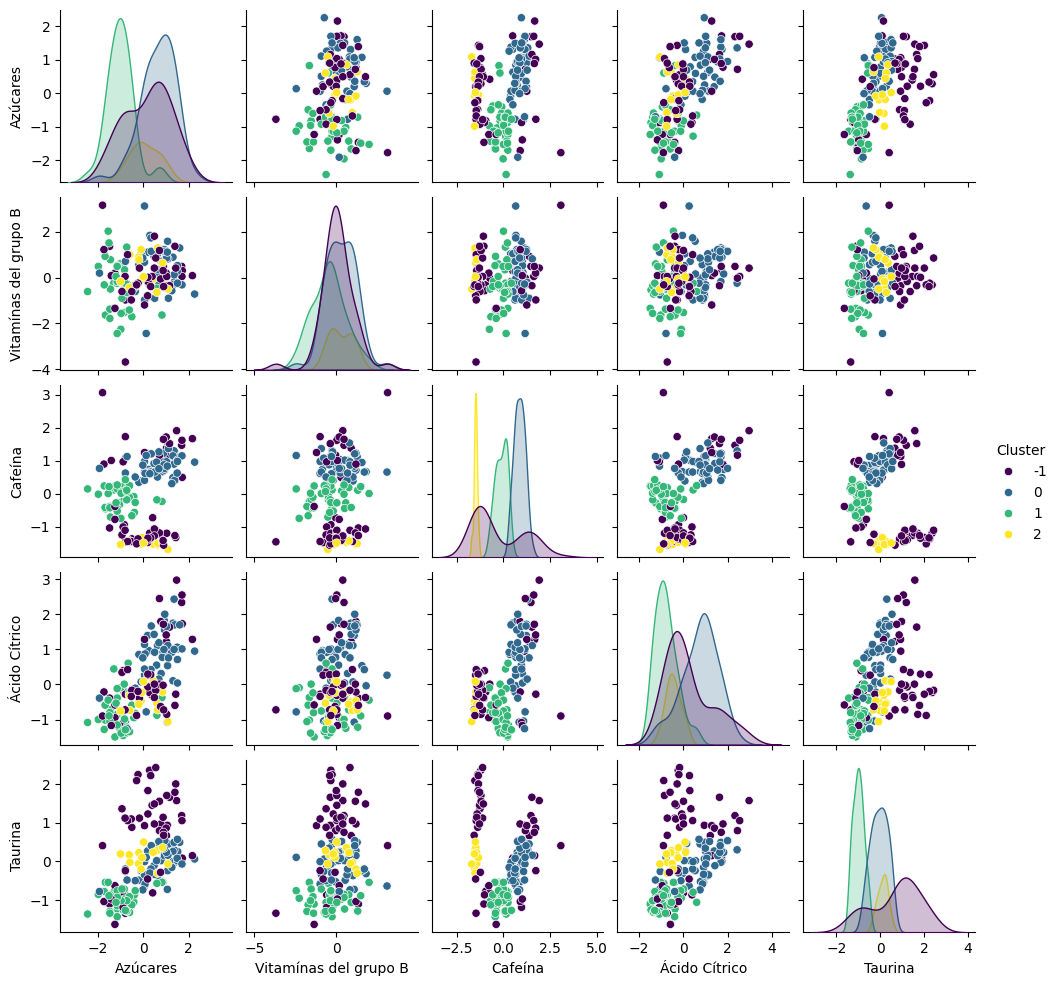

In [32]:
sns.pairplot(train_set_2feat, hue = "Cluster", palette="viridis", height=2)

<Axes: xlabel='Cafeína', ylabel='Taurina'>

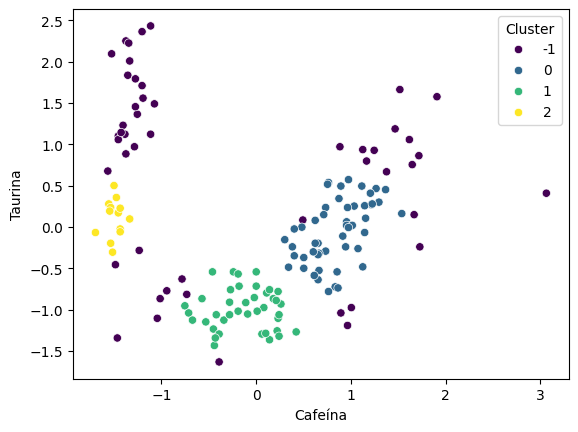

In [33]:
sns.scatterplot(data = train_set_2feat, x= "Cafeína", y = "Taurina", hue = "Cluster", palette="viridis")

*Demasiadas anomalías, al exigir 10 samples, probemos con 3*

##### **Min_samples = 5 - EPS: 0.3**

- Para min_samples de 5 vecinos: 4 clusters

In [46]:
train_set_2f = train_set.copy()

dbscan_5 = DBSCAN(eps = 0.3, 
                  min_samples = 5)

dbscan_5.fit(train_set[features_short])

train_set_2f["Cluster"] = dbscan_5.labels_

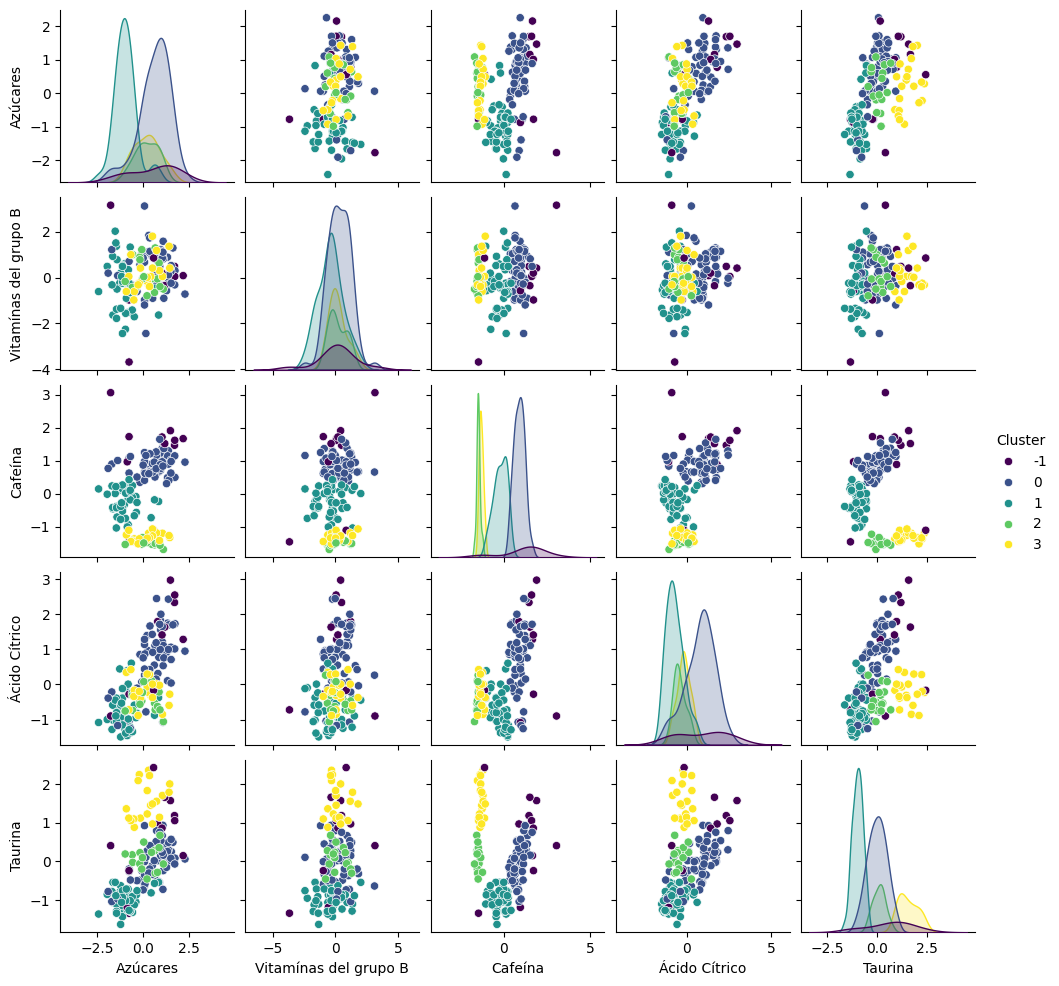

In [47]:
sns.pairplot(train_set_2f, hue = "Cluster", palette="viridis", height=2)

<Axes: xlabel='Cafeína', ylabel='Taurina'>

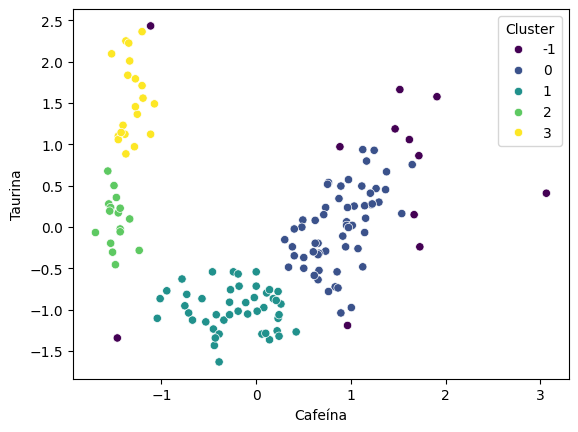

In [48]:
sns.scatterplot(data = train_set_2f, x = "Cafeína", y = "Taurina", hue = "Cluster", palette="viridis")

##### **Min_samples = 3 - EPS: 0.3**

- Para min_samples de 3 vecinos: 3 clusters

In [43]:
train_set_2f = train_set.copy()

dbscan_3 = DBSCAN(eps = 0.3, 
                  min_samples = 3)

dbscan_3.fit(train_set[features_short])

train_set_2f["Cluster"] = dbscan_3.labels_

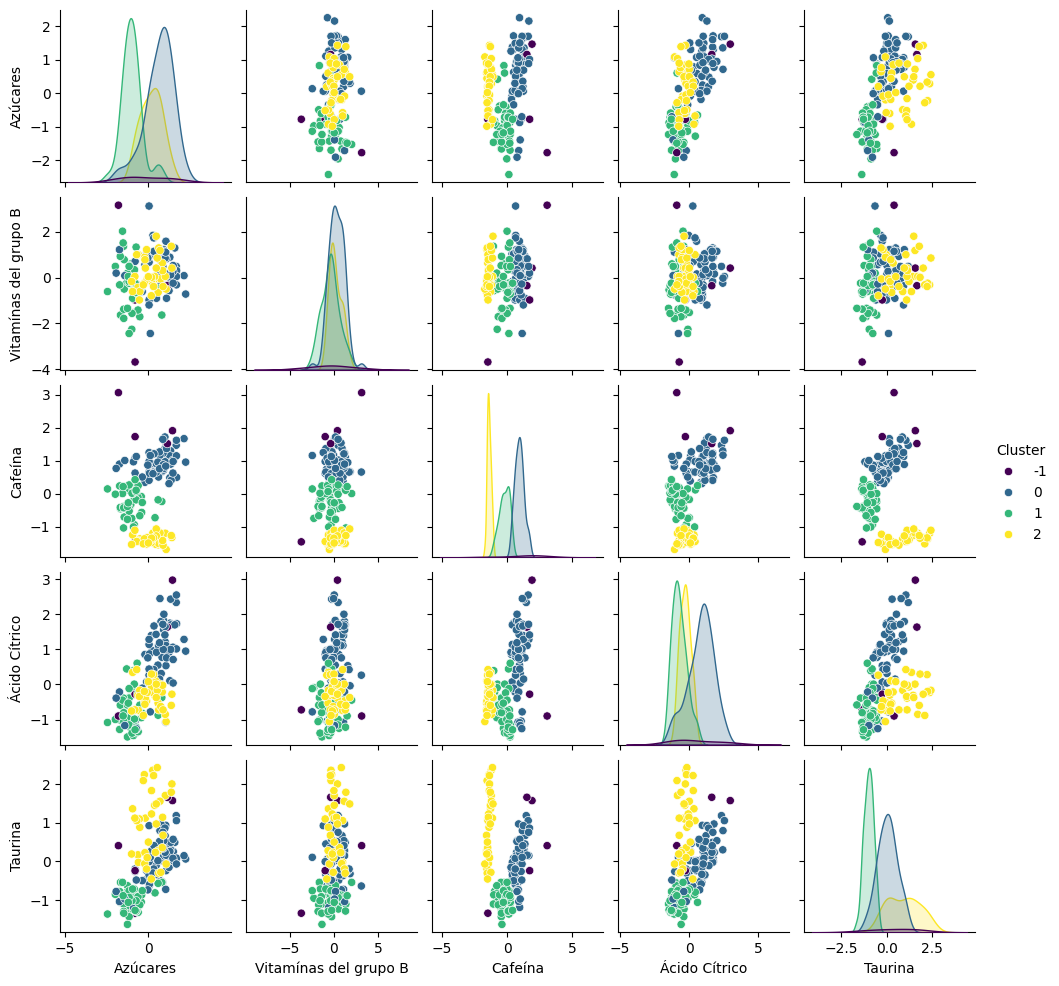

In [44]:
sns.pairplot(train_set_2f, hue = "Cluster", palette="viridis", height=2)

<Axes: xlabel='Cafeína', ylabel='Taurina'>

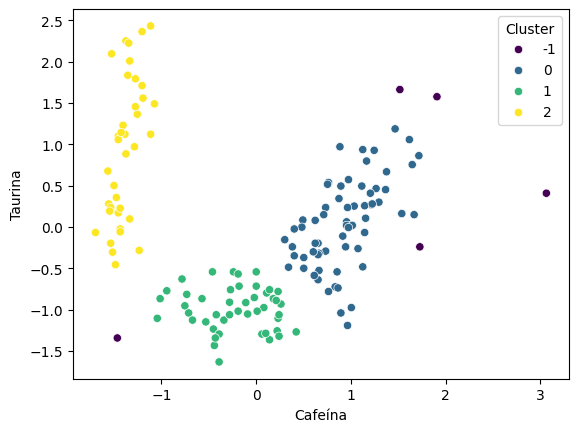

In [45]:
sns.scatterplot(data = train_set_2f, x = "Cafeína", y = "Taurina", hue = "Cluster", palette="viridis")

#### 5.1.3. Conclusion

Fijándonos directamente en las agrupaciones que parecían funcionar (*Cafeína-Taurina y Cafeína-Azucares*):
- para todas las features:
    - con eps = 1.2 y min_samples = 10  
    
- para dos features ("Cafeína" y "Taurina"):
    -  con eps=0.3, min_samples = 5

En el set de dos features, vemos que se mantienen el mismo num de cluster (3), pero además con menos anomalías, por tanto para este será el clustering DBSCAN seleccionado

### 5.2. **JERARQUICO**

*Lo primero para este caso es construirnos el dendrograma, como no nos dicen nada usaremos el método de linkage ward y además con la experiencia del clustering anterior vamos a usar únicamente las dos features más características que dieron buen resultado (Cafeína y Taurina)*

In [49]:
train_set[features_short]

Taurina   Cafeína
0    0.251717  1.034819
1   -0.293321  0.733629
2    0.269020  1.215533
3    1.186068  1.466525
4   -0.319276  0.663351
..        ...       ...
148  0.969783 -1.284344
149  2.224236 -1.344582
150  1.834923 -1.354622
151  1.791666 -1.274305
152  0.500000 -1.500000

[153 rows x 2 columns]

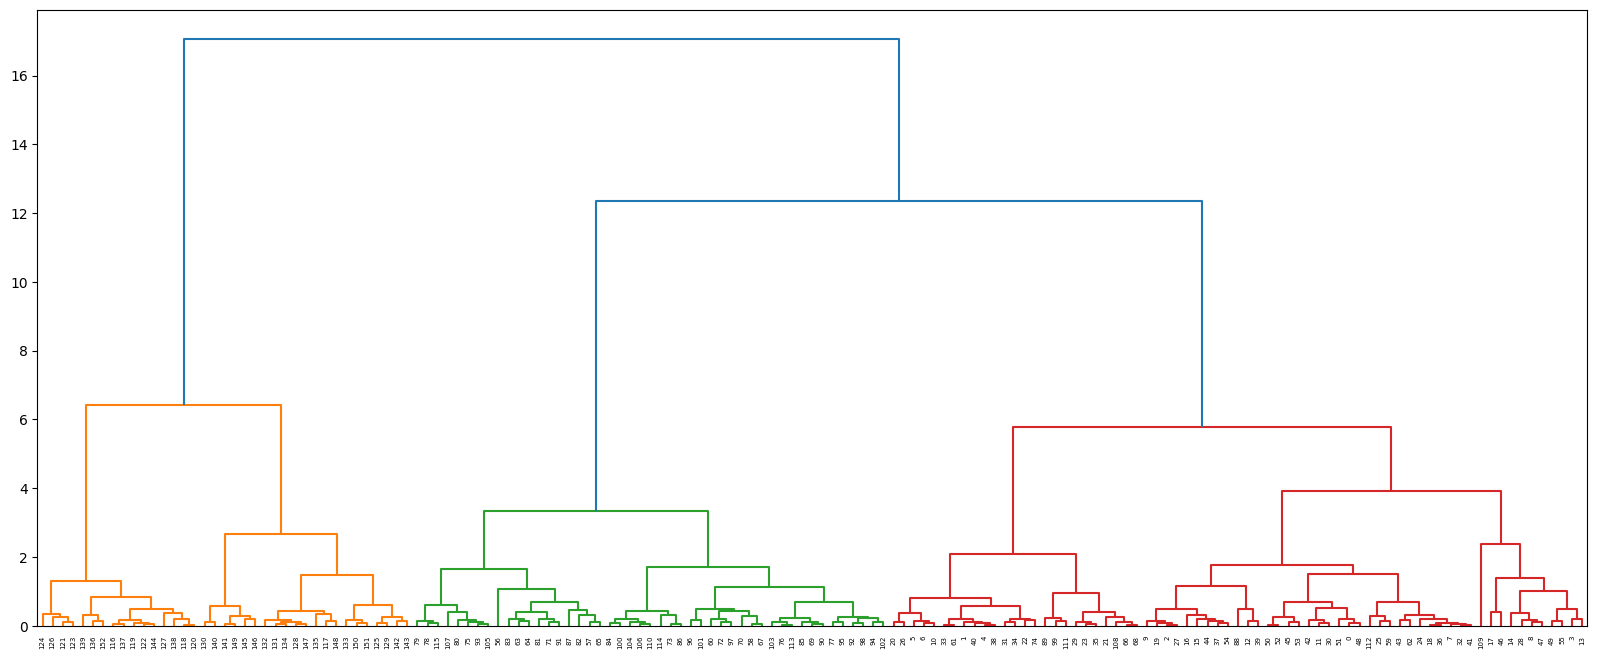

In [55]:
link_method = linkage(train_set[features_short], method = 'ward')
plt.figure(figsize =(20,8))
dend = dendrogram(link_method)

*Como ya comentamos, la función dendrogram de scipy directamente nos aplica el método del máximo gap y puedes ver que nos marca tres clusteres directamente*

*En cualquier caso, para que lo veamos más claramente superpongamos una linea vertical que aproveche el maximo gap horizontal, que está a una distancia superior a 7*

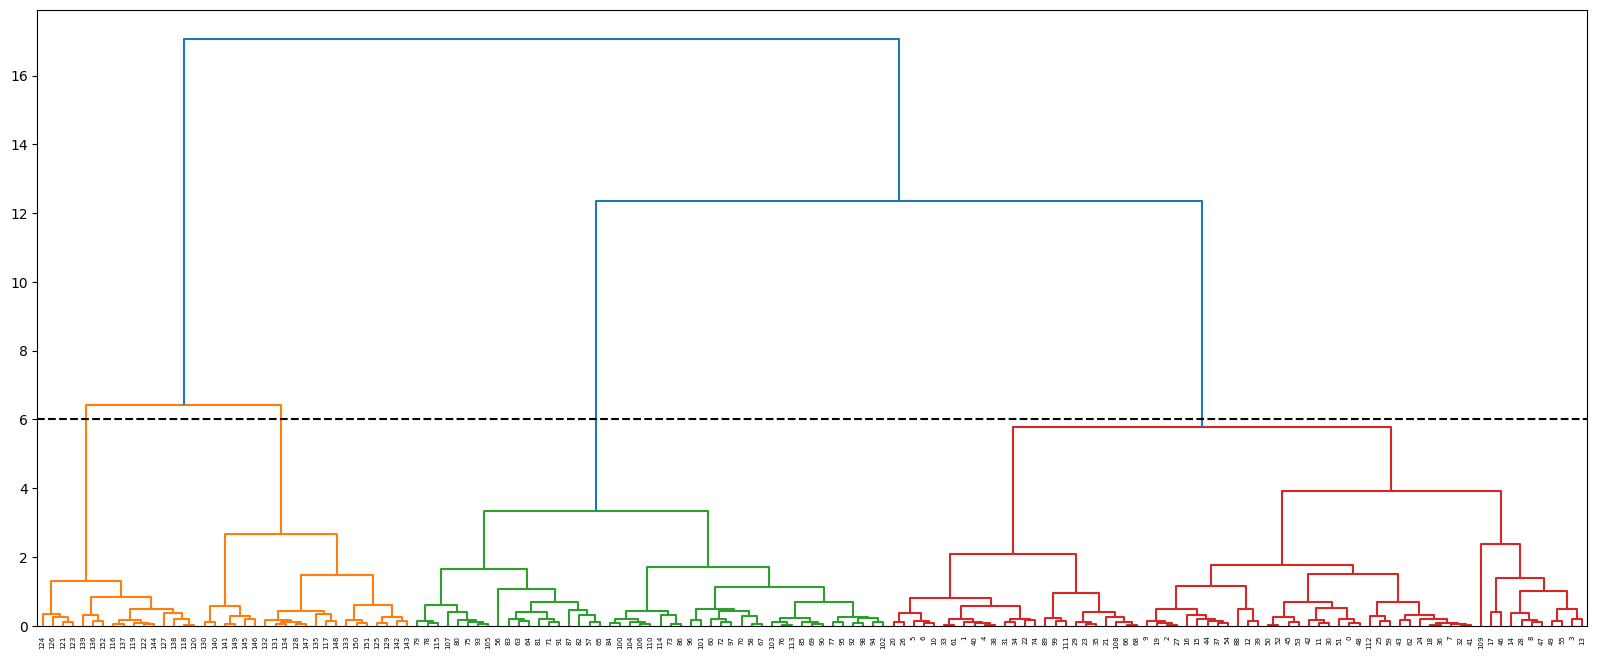

In [54]:
plt.figure(figsize =(20,8))
dend = dendrogram(link_method)
plt.axhline(y = 6, color = 'k', linestyle = '--')
plt.show()

*Aplicamos el clustering aglomerativo y comprobemos que tal queda el etiquetado comparándolo con DBSCAN anterior*

In [ ]:
clustering_model = AgglomerativeClustering(n_clusters=3,        
                                           metric='euclidean', 
                                           linkage='ward')

clustering_model.fit(train_set[features_short])

train_set_agg = train_set.copy()
train_set_agg['Cluster'] = clustering_model.labels_

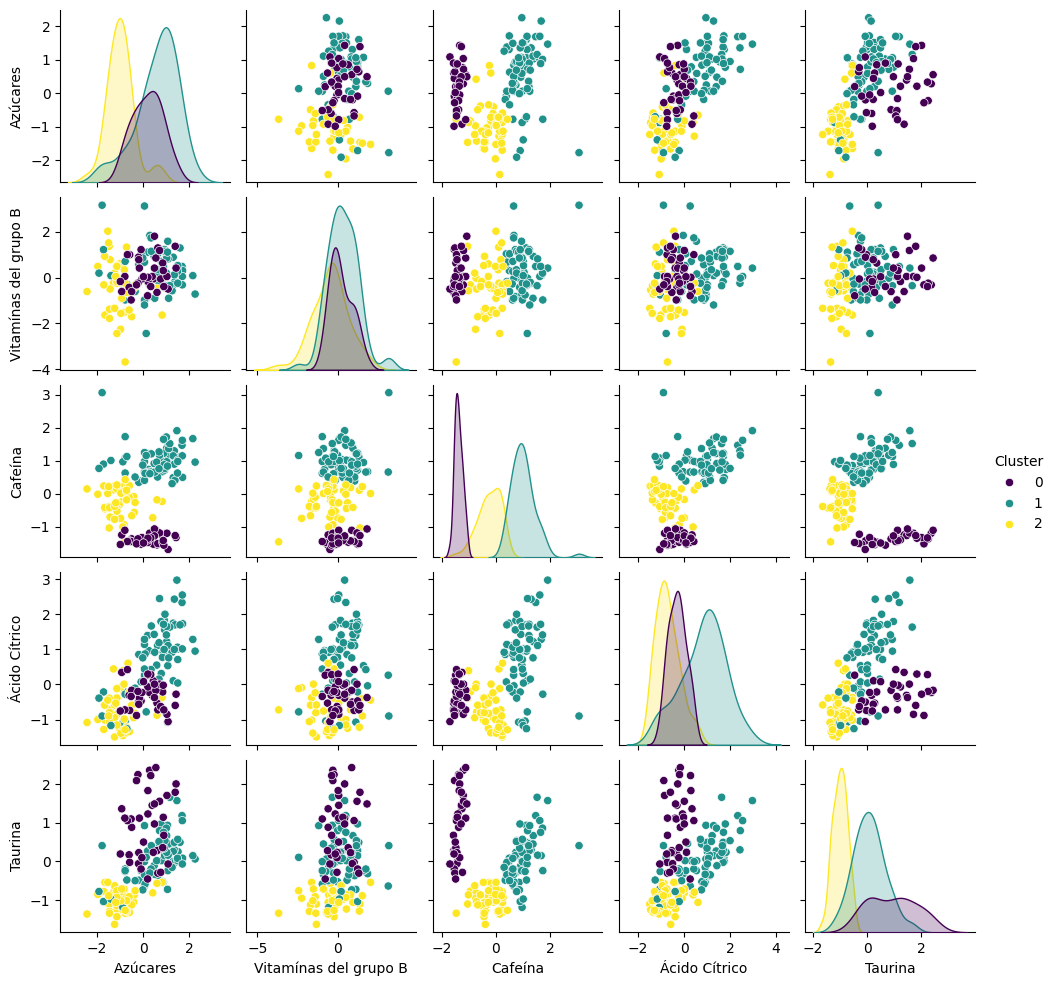

In [57]:
sns.pairplot(train_set_agg, hue = "Cluster", palette="viridis", height=2)

*Fijándonos en las parejas que habíamos destacado en DBSCAN (Taurina-Cafeína) los clusteres son muy similares por no decir iguales, ya que les diferencian que DBSCAN establece la existencia de anomalias y el aglomarativo los ha incorporado a unos de los tres posibles clusteres*

*Por otro lado, podemos comprobar a que color del dendrograma corresponde cada cluster y así además sabremos como de distantes están unos de otros para informar a los químicos y que estos valoren si tiene influencia en la energización de cada uno*

#### 5.2.2. Distancia entre clusteres

##### - 1. Metodo visual

*Para la distancia entre clusteres:*  
*1. Método visual. Identificamos cada cluster a través de alguno de sus miembros:*

In [58]:
clustering_model.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2,
       1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1,
       2, 1, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

In [59]:
train_set_agg["Cluster"].value_counts()

Cluster
1    69
2    47
0    37
Name: count, dtype: int64

In [60]:
# Escogemos un indice (mira los números en la base del dendrograma), el 124 es el primero en el cluster naranja
train_set_agg.loc[124] # Naranja 0

Azúcares                 0.765101
Vitamínas del grupo B   -0.060375
Cafeína                 -1.234146
Ácido Cítrico           -0.627005
Taurina                 -0.284670
Cluster                  0.000000
Name: 124, dtype: float64

*El cluster 0 es el cluster naranja*


In [61]:
train_set_agg.loc[1] # Roja 1

Azúcares                 0.246290
Vitamínas del grupo B   -0.827996
Cafeína                  0.733629
Ácido Cítrico            0.965242
Taurina                 -0.293321
Cluster                  1.000000
Name: 1, dtype: float64

*El cluster 1 es el cluster rojo*

In [62]:
print(f"Cluster naranja: {train_set_agg.loc[124]['Cluster']}")
print(f"Cluster verde: {train_set_agg.loc[79]['Cluster']}") # Cluster verde
print(f"Cluster rojo: {train_set_agg.loc[1]['Cluster']}")

Cluster naranja: 0.0
Cluster verde: 2.0
Cluster rojo: 1.0


*Y ahora vemos a "ojo" la distancia (la barra horizontal que los une):*

- *Rojo y Verde (cluster 2 y 1) están a algo más de 12 de distancia y estos a más de 18 del cluster 0, aunque por la posición en el dendrograma el cluster verde está más cerca del naranja que el rojo*

- *En este caso podríamos ordenar por 1,2,0 por ejemplo o a la inversa 0,2,1 los clusteres y serían los químicos los que nos deberían decir si esta ordenación (que te permite el clustering jerárquico) tiene un sentido real y aplicable o no*


##### - 2. Link method

*Este objeto es una matriz con valores [idx1, idx2, dist, num_instancias] y están ordenadas, de manera que las últimas entradas corresponden a los últimos clustering. Si te fijas en el dendrograma los tres clusters corresponden a los indices -5,-4,-3 (el antepenultimo, el anterior y el anterior)*

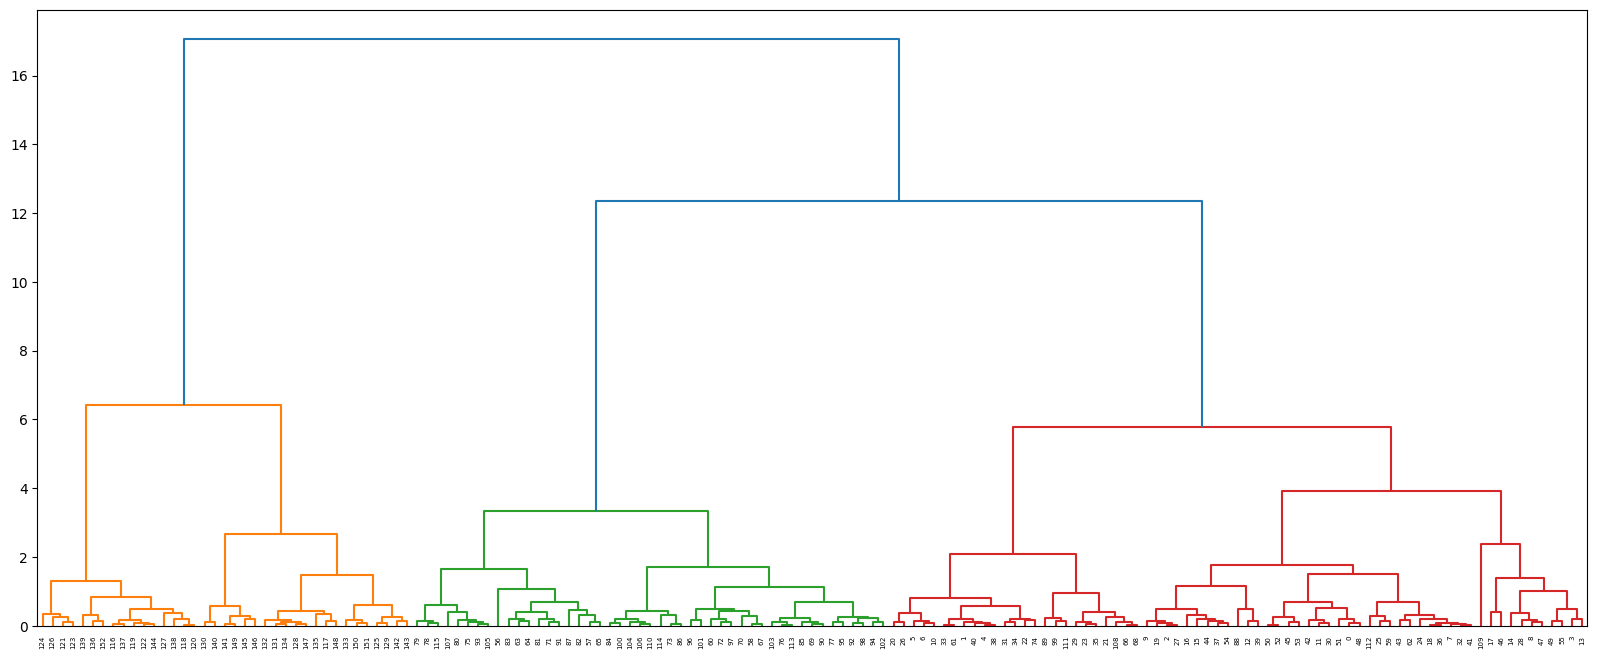

In [63]:
link_method = linkage(train_set[features_short], method = 'ward')
plt.figure(figsize =(20,8))
dend = dendrogram(link_method)

In [64]:
link_method[::-1]

array([[3.02000000e+02, 3.03000000e+02, 1.70596920e+01, 1.53000000e+02],
       [2.99000000e+02, 3.01000000e+02, 1.23411744e+01, 1.16000000e+02],
       [2.89000000e+02, 2.98000000e+02, 6.42831329e+00, 3.70000000e+01],
       [2.96000000e+02, 3.00000000e+02, 5.78672620e+00, 6.90000000e+01],
       [2.95000000e+02, 2.97000000e+02, 3.91456299e+00, 4.40000000e+01],
       [2.93000000e+02, 2.94000000e+02, 3.33685847e+00, 4.70000000e+01],
       [2.74000000e+02, 2.91000000e+02, 2.65562654e+00, 2.10000000e+01],
       [1.09000000e+02, 2.90000000e+02, 2.37800925e+00, 1.10000000e+01],
       [2.82000000e+02, 2.84000000e+02, 2.09800379e+00, 2.50000000e+01],
       [2.88000000e+02, 2.92000000e+02, 1.76988450e+00, 3.30000000e+01],
       [2.64000000e+02, 2.87000000e+02, 1.69884323e+00, 2.80000000e+01],
       [2.77000000e+02, 2.86000000e+02, 1.63948295e+00, 1.90000000e+01],
       [2.79000000e+02, 2.80000000e+02, 1.51587819e+00, 2.10000000e+01],
       [2.65000000e+02, 2.76000000e+02, 1.47003531e

In [65]:
link_method[-5:-2]

array([[295.        , 297.        ,   3.91456299,  44.        ],
       [296.        , 300.        ,   5.7867262 ,  69.        ],
       [289.        , 298.        ,   6.42831329,  37.        ]])

In [66]:
train_set_agg["Cluster"].value_counts()

Cluster
1    69
2    47
0    37
Name: count, dtype: int64

In [67]:
link_method[-2:]

array([[299.        , 301.        ,  12.34117438, 116.        ],
       [302.        , 303.        ,  17.05969203, 153.        ]])

*Aunque poco elegante porque hay que recurrir al numero de elementos para identificarlos, observa que la distancia entre 1 y 2 es de 12.34 y entre estos y el 0 de 17.05.*

# Parte II. Nuevos experimentos

Los químicos están muy esperanzados con los modelos que les habéis mostrado y os pasan una lista de nuevos experimentos para que los clasifiquéis. Emplea uno de los modelos construidos, el que te resulte más sencillo, para segmentar los nuevos experimentos que puedes encontrar en "./data/new_experiments.csv"

In [68]:
X_new = pd.read_csv("./data/new_experiments.csv", sep = "|")
X_new

Azúcares  Vitamínas del grupo B   Cafeína  Ácido Cítrico   Taurina
0  1.481555               0.305159  1.366128       2.239039  0.731870
1  0.616869               0.890014  0.583034       0.312420 -0.665332
2 -1.680724               0.341713 -0.340615      -0.213021 -0.976782
3 -0.284874              -1.412851 -0.782361      -1.193845 -0.717240
4 -0.927212               0.634140 -1.565455      -0.085641 -0.522583
5  0.962743              -0.243142 -1.354622      -0.420013  1.956043

### **Jerárquico**

*El problema con los jerárquicos es que debemos reconstruir todo el cluster con el problema que puede suponer (volvemos a reetiquetar), aunque también podemos acudir al método de utilizar el primer dataset ya etiquetado y entrenar un modelo sobre él*

In [69]:
new_train_set = pd.concat([train_set, X_new])

*Probamos con los anteriores valores de hiperparámetros, aunque pudiera ser necesario obtener unos nuevos*

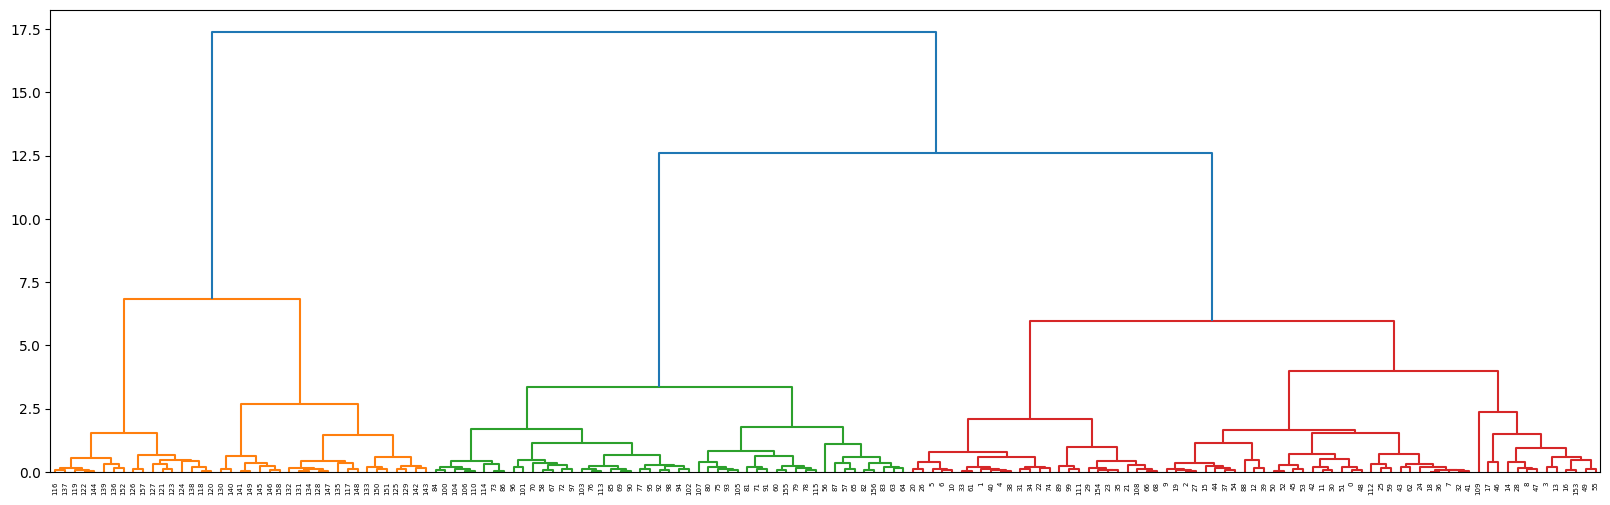

In [70]:
link_method = linkage(new_train_set[features_short], method = 'ward')
plt.figure(figsize =(20,6))
dend = dendrogram(link_method)

*Nada parace haber cambiado, obtengamos el cluster y las etiquetas asignadas a los nuevos experimentos*

In [71]:
clustering_model = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
clustering_model.fit(new_train_set[features_short])

new_train_set_agg = new_train_set.copy()
new_train_set_agg['Cluster'] = clustering_model.labels_

In [72]:
new_train_set_agg.tail(len(X_new))

Azúcares  Vitamínas del grupo B   Cafeína  Ácido Cítrico   Taurina  Cluster
0  1.481555               0.305159  1.366128       2.239039  0.731870        1
1  0.616869               0.890014  0.583034       0.312420 -0.665332        1
2 -1.680724               0.341713 -0.340615      -0.213021 -0.976782        2
3 -0.284874              -1.412851 -0.782361      -1.193845 -0.717240        2
4 -0.927212               0.634140 -1.565455      -0.085641 -0.522583        0
5  0.962743              -0.243142 -1.354622      -0.420013  1.956043        0

### **DBSCAN**

*Con la aproximación DBSCAN podríamos hacer igual que con el jerárquico, volver a modelar, pero lo que vimos es que normalmente se procede obteniendo un modelo de clasificación a partir del dataset inicial ya etiquetado y eso vamos a hacer. Aprovechando el escalado y como repetición de lo visto en el workout vamos a utilizar un KNN, optimizando el hiperparámetro k*

In [73]:
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()
target = "Cluster"
X_train = train_set_2f.drop(target, axis = 1) # No uso dataset de test, porque no lo necesito, optimizare con cross_val y predeciremos contra X_new
y_train = train_set_2f[target]


In [74]:
param_grid = {
    "n_neighbors": [2,3,5,10],
    "weights": ["uniform","distance"]
}

knn_grid = GridSearchCV(knn,
                        param_grid = param_grid,
                        cv = 4, # un "train-test" split un poco mayor del 20%
                        scoring = "balanced_accuracy" # Multiclase en el que todos son importantes
                        )

knn_grid.fit(X_train, y_train)


GridSearchCV(cv=4, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 3, 5, 10],
                         'weights': ['uniform', 'distance']},
             scoring='balanced_accuracy')

In [75]:
knn_grid.best_params_

{'n_neighbors': 2, 'weights': 'distance'}

In [76]:
knn_grid.best_score_

0.8216666666666665

In [77]:
from sklearn.metrics import classification_report

print(classification_report(y_train, knn_grid.best_estimator_.predict(X_train)))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        12
           0       1.00      1.00      1.00        59
           1       1.00      1.00      1.00        46
           2       1.00      1.00      1.00        16
           3       1.00      1.00      1.00        20

    accuracy                           1.00       153
   macro avg       1.00      1.00      1.00       153
weighted avg       1.00      1.00      1.00       153



*Ha logrado copiar el clustering :-) con un buen overfitting, lo cual era importante porque nuestro train en realidad es nuestra población, asignemos ahora a las nuevas instancias*

In [78]:
y_pred = knn_grid.best_estimator_.predict(X_new)

In [79]:
X_new["Cluster"] = y_pred

In [80]:
X_new

Azúcares  Vitamínas del grupo B   Cafeína  Ácido Cítrico   Taurina  Cluster
0  1.481555               0.305159  1.366128       2.239039  0.731870       -1
1  0.616869               0.890014  0.583034       0.312420 -0.665332        0
2 -1.680724               0.341713 -0.340615      -0.213021 -0.976782        1
3 -0.284874              -1.412851 -0.782361      -1.193845 -0.717240        1
4 -0.927212               0.634140 -1.565455      -0.085641 -0.522583        2
5  0.962743              -0.243142 -1.354622      -0.420013  1.956043        3

*Comprobemos que son las mismas asignaciones que con el jerárquico aunque con el nombre de las etiquetas cambiado*

In [81]:
train_set_2f.head()

Azúcares  Vitamínas del grupo B   Cafeína  Ácido Cítrico   Taurina  Cluster
0  1.518613               0.232053  1.034819       1.013009  0.251717        0
1  0.246290              -0.827996  0.733629       0.965242 -0.293321        0
2  0.196879               1.109334  1.215533       1.395148  0.269020        0
3  1.691550               0.487926  1.466525       2.334574  1.186068       -1
4  0.295700               1.840403  0.663351      -0.037874 -0.319276        0

In [82]:
new_train_set_agg.head()

Azúcares  Vitamínas del grupo B   Cafeína  Ácido Cítrico   Taurina  Cluster
0  1.518613               0.232053  1.034819       1.013009  0.251717        1
1  0.246290              -0.827996  0.733629       0.965242 -0.293321        1
2  0.196879               1.109334  1.215533       1.395148  0.269020        1
3  1.691550               0.487926  1.466525       2.334574  1.186068        1
4  0.295700               1.840403  0.663351      -0.037874 -0.319276        1

In [83]:
train_set_2f.merge(new_train_set_agg, left_index = True, right_index = True, suffixes =["_DBSCAN","_Agglo"])[["Cluster_DBSCAN","Cluster_Agglo"]].value_counts()

Cluster_DBSCAN  Cluster_Agglo
 0              1                61
 1              2                46
 3              0                20
 2              0                16
-1              1                10
                2                 2
 0              0                 2
-1              0                 1
 0              2                 1
Name: count, dtype: int64

Quitando las anomalias de DBSCAN y algunos puntos de no coincidencia en los clusteres: 
- la clase 0 de DBSCAN corresponde a la 1 de Agglo, 
- la 1 a la 2 
- y la 2 a la 0

# Parte III. EXTRA (Voluntario): 6 meses después...

La unidad de experimentación recibió un presupuesto adicional gracias a los modelos que les proporcionastes e hizo pruebas con cliente y obtuvo resultados como para clasificar cada bebida en terminos de "energización" en tres niveles (1, media; 2, media-alta, 3, alta). El resultado de los mismos está en el fichero adecuado en el directorio data y alineado con los experimentos iniciales y al final con los nuevos experimentos de la parte anterior.

Evalua la segmentación de los modelos creados en la primera parte.